# Does Form follow Function?
### Building Types Classification Case Study Hamburg

Data Science for Spatial Systems Courswork - Melanie Imfeld <br>
<br>
Data analysis: Python Version 3.6.2 <br>
Preprocessing: QGIS Version Las Palmas 2.18

<hr style= "height: 1px;">

### Overview Notebook

0. Introduction
2. Metadata
3. Clean and reshape dataset
4. Exploring the dataset
    * 4.1 independent variable
    * 4.2 dependent variables
    * 4.3 conclusions, summary deleted values
5. Prepare for classification
    * 5.1 dummy variables
    * 5.2 feature selection
6. Classification KnN
    * 6.1 initial runs
    * 6.2 inital results
    * 6.3 Gridsearch
7. Classification decision tree
    * 7.1 initial runs
    * 7.2 Gridsearch and pipelining
8. Results
9. Limitations
10. References

# 1) Introduction and objectives

We all know that 'form follows function', a mantra coined by the Chicago School at the beginning of the 20th century. Can we verify this by implementing an algorithm to predict function based on form characteristics such as area, complexity of shape and height? If so, which variables are the best predictors? Can we even go further and see if form is also able to predict the age of the building?
The shapebased features are largely taken from the dataset created by Michael Wurm. 

Functions: http://suche.transparenz.hamburg.de/dataset/alkis-liegenschaftskarte-ausgewahlte-daten-hamburg15?forceWeb=true

Metadata: http://www.adv-online.de/AAA-Modell/ALKIS/broker.jsp?uMen=4ad505ea-127b-b941-2df2-65a572e13d63

Shapeanalysis: M. Wurm (DLR)

The data has been preprocessed in QGIS

Structure of notebook:
    - Introduction & hypothesis: explain terminology
    - Data
    - Methodology
        - group targets into larger groups
        - add a proximity feature (no of buildings within buffer): https://gis.stackexchange.com/questions/223698/count-the-number-of-buffers-intersecting-with-zip-code-polygons
        - find a code to loop through train and test sets to get different ones (kfold)
        - install basemap
        - normalisation of values
        - cross validation to (why crossvalidate: to avoid overfitting): 
            - test different hyperparameters (for each classifier) gridsearch
            - kfold cross validation
            - dimensionality reduction, eg PCA. Test with Kaiser/ Average Root criterion (Steiniger S,Paper)
    - Results
    - Limitations
    - conclusion
    - References
  

### Questions

Methods so far: <br>
###1) check out the variable to be predicted: very skewed and some values very sparse<br>
        aggregate to a higher level, exclude values that are still too small <br>
###2) check out independent variables. <br>
        discrete values: how discrete values relate to function<br>
        discrete values: look at correlation between inpendentent values<br>
        year built, roof type, construction type 

###4) Classification: <br>
        kNN, grid search <br>
        SGD, grid search <br>
        
###4) Feature selection: <br> 
        PCA
        Univariate test: chi squared
        
###5) Results: <br>
        find out how to plot shapefiles <br>      
        
     

| This | is   |
|------|------|
|   a  | table|

$$e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i$$

## methods:

0) explore the dependent variable 'building function'

1) explore other datatypes:
- geometry features: discrete
- storeys: ordinal
- roofshape: nominal
- constructiontype: nominal
- year built: ordinal
- vertices: ordinal
- lon/lat center: discrete

2) explore relation between dependent and independent variables. relative frequency of a building function (mosaic plot between categorical variables)

https://seaborn.pydata.org/tutorial/categorical.html

3) measure strength of association?

4) Supervised learning: Supervised learning consists in learning the link between two datasets: the observed data X and an external variable y that we are trying to predict, usually called “target” or “labels”

5) Unsupervised learning: spatial clustering to predict usage. Spatial correlcation?

known limitations:
- datamerge: randomly assignes function to unionized buildingblock. more of a problem in the inner city
- question: use buildingblock or individual registered building?
- plenty of false data

# 0) Metadata

- Pandas 0.20.3
- Matplotlib 2.0.2
- Seaborn 0.8.0
- Sklearn 0.19.0
- mpl_toolkits.axes_grid1 (Version unknown)
- Graphviz 0.8.2

In [15]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import numpy as np
pd.set_option('display.max_rows', 300)
%matplotlib inline

In [16]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [364]:
roof = pd.read_csv('_basedata/roof_key.txt')
functions_key = pd.read_csv('_basedata/functions2.txt')
typo_key = pd.read_csv('_basedata/typology.txt')

In [ ]:
data_key = pd.read_csv('_basedata/data_key.txt')
data_key

In [ ]:
roof

In [ ]:
functions_key
#pd.DataFrame.to_csv(functions_key, path_or_buf=path, sep=',')
#functions_key.to_csv('functions2', sep=',')

In [365]:
typo_key

,type,value
0,Single detached building,1100
1,Detached building block,1200
2,Single garage,1300
3,Double garage,1400
4,Collective garage,1500
5,Half of duplexhouse,2100
6,Rowhouse,2200
7,House in a row,2300
8,Connected building group,2400
9,Perimeterblock,2500


# 2) Clean and reshape dataset

In [359]:
#buildings.dachform
buildings = pd.read_csv('_basedata/buildings.csv',sep='\t', index_col=0)

/Users/myveryself/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
buildings.head()

,FUNC,STOR,ROOF,AREA,CONS,YEAR,PERI,VERT,CENX,CENY,DENS,RADR
0,2700,1.000,3100.000,113.000,nan,NaN,43,4,582582,5921339,4.000,0.597
1,2741,1.000,3100.000,596.000,nan,NaN,106,4,582556,5920798,4.000,0.402
2,2463,1.000,3100.000,107.000,nan,NaN,43,4,583171,5920187,1.000,0.489
3,2463,1.000,3100.000,51.000,nan,NaN,29,4,583387,5920419,6.000,0.690
4,2741,1.000,3100.000,104.000,nan,NaN,47,11,582886,5920464,4.000,0.345


In [8]:
#buildings.FUNC.value_counts()

In [9]:
buildings['AREA'].groupby(buildings['FUNC']).describe()
buildings['STOR'].groupby(buildings['FUNC']).describe()

,count,mean,std,min,25%,50%,75%,max
FUNC,,,,,,,,
1000,16615.000,1.034,0.212,1.000,1.000,1.000,1.000,7.000
1010,178705.000,1.895,1.269,1.000,1.000,2.000,2.000,29.000
1020,1015.000,2.783,1.641,1.000,2.000,2.000,3.000,19.000
1024,1.000,7.000,nan,7.000,7.000,7.000,7.000,7.000
1025,2.000,1.500,0.707,1.000,1.250,1.500,1.750,2.000
1100,11881.000,1.878,1.406,1.000,1.000,1.000,2.000,26.000
1110,55.000,2.964,1.763,1.000,2.000,3.000,4.000,10.000
1120,5837.000,3.352,1.886,1.000,2.000,3.000,5.000,26.000
1121,11.000,1.636,0.505,1.000,1.000,2.000,2.000,2.000


In [10]:
buildings.describe()
buildings.dtypes
type(buildings.iloc[8,5])
#buildings['YEAR'] = buildings['YEAR'].replace(0, np.nan)
#buildings2.iloc[:,5]
buildings

,FUNC,STOR,ROOF,AREA,CONS,YEAR,PERI,VERT,CENX,CENY,DENS,RADR
0,2700,1.000,3100.000,113.000,nan,NaN,43,4,582582,5921339,4.000,0.597
1,2741,1.000,3100.000,596.000,nan,NaN,106,4,582556,5920798,4.000,0.402
2,2463,1.000,3100.000,107.000,nan,NaN,43,4,583171,5920187,1.000,0.489
3,2463,1.000,3100.000,51.000,nan,NaN,29,4,583387,5920419,6.000,0.690
4,2741,1.000,3100.000,104.000,nan,NaN,47,11,582886,5920464,4.000,0.345
5,2520,1.000,1000.000,20.000,nan,NaN,19,4,582176,5920279,1.000,0.424
6,1010,3.000,3100.000,99.000,1100.000,NaN,43,12,582571,5921264,8.000,0.612
7,2140,1.000,3100.000,48.000,nan,NaN,32,4,582447,5920907,4.000,0.317
8,1010,1.000,3100.000,165.000,1100.000,(1:2015),61,12,582332,5921194,3.000,0.341
9,1010,1.000,3200.000,136.000,1100.000,(1:1987),47,5,583362,5920102,5.000,0.599


#### clean up year column

In [360]:
buildings['YEAR'] = buildings['YEAR'] .astype(str).str.replace('\D', '')
buildings.iloc[:,5]

buildings['YEAR'] = buildings['YEAR'].str[-4:]

buildings['YEAR'] = buildings['YEAR'] .replace('','0')
buildings['YEAR']= buildings['YEAR'] .astype(int)
#buildings2.baujahr2.value_counts()
type(buildings.iloc[8,11])
buildings.dtypes

FUNC      int64
STOR    float64
ROOF    float64
AREA    float64
CONS    float64
YEAR      int64
PERI      int64
VERT      int64
CENX      int64
CENY      int64
DENS    float64
RADR    float64
dtype: object

In [ ]:
buildings.YEAR.value_counts()
buildings.count()
buildings

In [ ]:
len(buildings)
buildings.dtypes

# 3) Exploring the dataset

## 3.1) Dependent variable : Building functions (categorical data)

See p.5.

1000 : 1st hierarchical order (should not be assigned)

1100 : mixed use

1010 : mid hierarchical order

1011 : lowest hierarchical order (shold be assigned whenever possible)

In the metadata it is stated that buildigs are classified according to the information accessible. In our case, buildings are assigned to different hierarcical orders, indicating less information on some buildings. Therefore it might make sense to aggregate them to the highest possible order, as we are unable to specify those buildings that are assigned to a high hierarchical order. 

1000: Residential

In [368]:
#count frequency of functions
functions = pd.DataFrame(buildings.FUNC.value_counts())
functions = functions.reset_index()
functions

functions_norm = pd.DataFrame(buildings.FUNC.value_counts(normalize=True))
len(functions_norm)

170

In [369]:
functions = pd.merge(functions, functions_key, left_on=['index'], right_on=['value'], how='left')
functions = functions[functions.FUNC > 200]
functions.head()

,index,FUNC,Unnamed: 0,type,value
0,1010,178845,1.000,Wohnhaus,1010.000
1,2463,60651,101.000,Garage,2463.000
2,1313,36319,24.000,Gartenhaus,1313.000
3,1000,16703,0.000,Wohngebaeude,1000.000
4,1100,11881,8.000,Gemischt genutztes Gebaeude mit Wohnen,1100.000


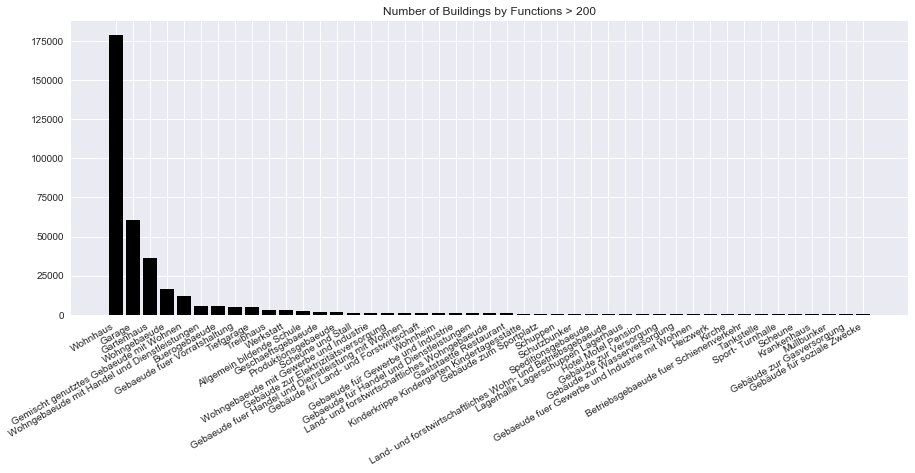

In [372]:
def draw_bar(data, col, title, label):
    fig1=plt.figure(3, figsize=(15,6))
    plt.bar(range(len(data)), data[col],width=0.8,tick_label=label, color ='k')
    plt.title(title)
    fig1.autofmt_xdate()
    
functionplot = draw_bar(functions,'FUNC', 'Number of Buildings by Functions > 200', functions.type)

### Data is very skewed. Out of the 170 classifications as expected 90% are residential buildings, followed by garages, little public buildings. Let's just map the classifications that contain more than 200 buildings

### About imbalanced samples

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

- oversampling the underrepresented class (SMOTE or the Synthetic Minority Over-sampling Technique)
- undersampling the overrepresented class


imbalanced samples: A popular approach towards solving class imbalance problems is to bias the classifier so that it pays more attention to the positive instances. This can be done, for instance, by increasing the penalty associated with misclassifying the positive class relative to the negative class. Another approach is to preprocess the data by oversampling the majority class or undersampling the minority class in order to create a balanced dataset.

SGDClassifier and naïve bayes - SVM is extremely slow!

https://stackoverflow.com/questions/2595176/which-machine-learning-classifier-to-choose-in-general
https://stats.stackexchange.com/questions/79622/comparing-different-classifiers-using-ski-kit-cross-validation-values

maybe we can guess that the classification will work better with the ones that have more data than then building functions that have only very little data. 

 ### However we can also see that classification contains different hierarchical orders, depending on the available information. This can be a problem, because it looks at buildings labelled 1000 and buildings labelled with 1010 as a different class, despite 1010 being a sub-class of 1000.

## aggregate building functions to the highest hierarchical level

- 1000: Residential
- 1010: Single family
- 1100: Mixed use including residential
- 2000: Commerical retail & office
- 2100: Commerical industrial: plants
- 2400: Infrastructure purposes: trainstations, parking garages
- 2500: Supply: water, energy, gas
- 2600: Waste: waste water, solid waste
- 2700: Agriculture: barn 
- 9999: else

In [ ]:
sample = buildings

for index, row in enumerate(sample.FUNC):
  
    #print(sample.loc[index,'FUNC'])

    if str(row)[:2] == '10':
        #print('yes')
        sample.loc[index,'FUNC2']=1000
  
    elif str(row)[:2] == '11':
        #print('yes')
        sample.loc[index,'FUNC2']=1100
    
    elif str(row)[:2] == '20':
        #print('yes')
        sample.loc[index,'FUNC2']=2000
        
    elif str(row)[:2] == '21':
        #print('yes')
        sample.loc[index,'FUNC2']=2100
    
    elif str(row)[:2] == '24':
        #print('yes')
        sample.loc[index,'FUNC2']=2400
    
    elif str(row)[:2] == '25':
        #print('yes')
        sample.loc[index,'FUNC2']=2500
    
    elif str(row)[:2] == '26':
        #print('yes')
        sample.loc[index,'FUNC2']=2600
    
    elif str(row)[:2] == '27':
        #print('yes')
        sample.loc[index,'FUNC2']=2700
    
    elif str(row)[:2] == '30':
        #print('yes')
        sample.loc[index,'FUNC2']=3000
    
    elif str(row)[:2] == '32':
        #print('yes')
        sample.loc[index,'FUNC2']=3200
        
    else:
        #print('no')
        sample.loc[index,'FUNC2']=9999

In [ ]:
sample.head()

### also, the dataset clearly does not differentiate between multifamily housing and single family houses. let's assume that all buildings classified as 10xx with an area under 100sqm and only one story cannot be multfamily homes (min area : 5.000  , max area: 7068.000)

In [ ]:
sample.loc[(sample['AREA'] <= 100) & (sample['STOR'] <= 1) & (sample['FUNC2'] == 1000), 'FUNC2'] = 1010

In [ ]:
sample[sample['FUNC2'] == 1010]

In [ ]:
sample.to_csv('_basedata/buildings_agg.csv',sep='\t')

## read in aggragate file to save time

In [424]:
buildings_agg = pd.read_csv('_basedata/buildings_agg.csv',sep='\t', index_col=0)
buildings_agg.dtypes

FUNC       int64
STOR     float64
ROOF     float64
AREA     float64
CONS     float64
YEAR       int64
PERI       int64
VERT       int64
CENX       int64
CENY       int64
DENS     float64
RADR     float64
FUNC2    float64
dtype: object

In [422]:
len(buildings_agg)

363310

In [388]:
functions=pd.DataFrame(buildings_agg.FUNC2.value_counts())

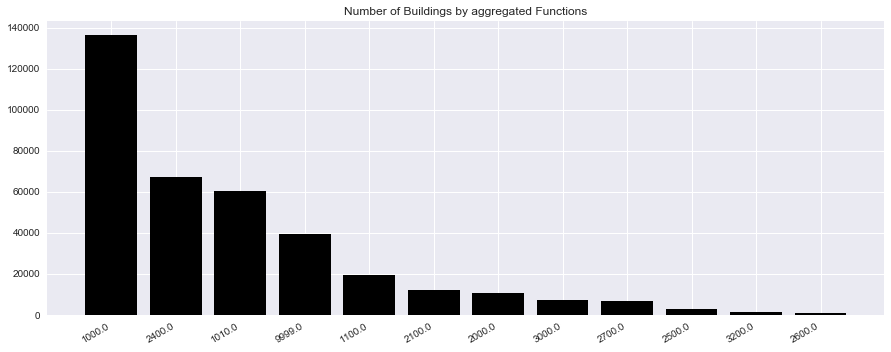

In [390]:
draw_bar(functions,'FUNC2', 'Number of Buildings by aggregated Functions', functions.index)

### Oh no: there is still one class with only one value. Let's exclude all classes that are smaller than 36, because it might create problems later when we split the data into train and test set

In [425]:
buildings_agg = buildings_agg.loc[buildings_agg['FUNC2'].isin([1000,1010,2400,2100,1100])]
buildings_agg = buildings_agg.reset_index(drop=True)

In [396]:
len(buildings_agg)

295194

In [426]:
#drop all zero values except years
buildings_agg = buildings_agg.dropna()
len(buildings_agg)
#buildings_agg.tail()

190822

`YEAR` and `CONS` zero values are still in there, we will look at these later.

In [319]:
buildings_agg.tail()

,FUNC,STOR,ROOF,AREA,CONS,YEAR,PERI,VERT,CENX,CENY,DENS,RADR,FUNC2
190817,1100,3.000,1000.000,100.000,2100.000,0,44,16,566079,5939420,5.000,0.546,1100.000
190818,1010,4.000,1000.000,1038.000,2500.000,0,204,27,566797,5938395,2.000,0.073,1000.000
190819,1010,1.000,3100.000,113.000,2100.000,0,47,8,566323,5938998,10.000,0.440,1000.000
190820,1010,4.000,3100.000,605.000,2500.000,0,133,10,566520,5938537,1.000,0.246,1000.000
190821,1010,5.000,3200.000,495.000,2400.000,0,102,35,567301,5938060,3.000,0.397,1000.000


In [351]:
len(buildings_agg)

295194

In [28]:
#buildings_agg1[buildings_agg1.AREA < 4]
buildings_agg.AREA.describe()

count   190858.000
mean       162.450
std        230.922
min          3.000
25%         75.000
50%        111.000
75%        173.000
max      34458.000
Name: AREA, dtype: float64

## 3.2) Exploring the independent variables 

### The features explained
ellips_1 = radius of the largest enclosed ellipse

elliptic = a measure of how well an object fits into an ellipse

roundness = difference between the enclosing and the enclosed ellipse

nPeriInd = index proportion of Perimeter of a cicle with the same area WITH perimeter of building (?)

SI_2D = smoothness of outer shape. prop of perimeter and square with same area as object

frac = complexity of an object as a proportion of area and perimeter

dens2D = high values represent similarity to a square and low values represent similarity to long elements

rectang = compares object to rectangle. 0 no similarity, 1 high similarity

asymm2D, aysmm 3D = relative length of object compared to a regular object

leng_main, width_main = length and width of longest element?

comp2d = similar to perimeter index, but based on area rather than perimeter

### 3.2.1) Geometry features

In [405]:
#transform the categorical features from floats into categories
buildings_agg["ROOF"] = buildings_agg["ROOF"].astype('category')
buildings_agg["CONS"] = buildings_agg["CONS"].astype('category')
buildings_agg["FUNC2"] = buildings_agg["FUNC2"].astype('category')

In [406]:
geom1 = buildings_agg.loc[:, ['AREA','PERI','VERT','RADR','FUNC2', 'STOR','DENS']]

summary_stats = geom1.describe()
stdevs = summary_stats.loc['std']
means = summary_stats.loc['mean']

# Create and add a standardised column for each column to the original dataframe :

for col in geom1.columns:
    print(col)
    if ((col == 'AREA')|(col =='PERI')|(col =='VERT')|(col =='RADR')|(col =='STOR')|(col =='DENS')):
        #print('yes')
        geom1[col + '_stand'] = (geom1[col] - means[col])/ stdevs[col]
            
geom2 = geom1.loc[:, ['AREA_stand','PERI_stand','VERT_stand','RADR_stand','STOR_stand','DENS_stand','FUNC2']]

geom2.describe()
geom1.describe()
#geom2.dtypes
geom2.head()

AREA
PERI
VERT
RADR
FUNC2
STOR
DENS


,AREA_stand,PERI_stand,VERT_stand,RADR_stand,STOR_stand,DENS_stand,FUNC2
2,-0.276,-0.329,0.247,0.922,0.916,1.718,1000.000
4,0.011,0.212,0.247,-0.860,-0.758,-0.505,1000.000
5,-0.115,-0.209,-0.445,0.839,-0.758,0.384,1000.000
10,0.151,0.212,-0.148,-0.820,0.079,-0.061,1000.000
11,-0.428,-0.539,-0.050,0.241,-0.758,0.829,1010.000


In [354]:
grouped = geom1.groupby('FUNC2')
grouped.DENS.describe()

,count,mean,std,min,25%,50%,75%,max
FUNC2,,,,,,,,
1000.000,136360.000,4.088,2.335,0.000,2.000,4.000,5.000,22.000
1010.000,60209.000,4.728,2.321,1.000,3.000,4.000,6.000,22.000
1100.000,19322.000,3.578,1.826,0.000,2.000,3.000,5.000,20.000
2100.000,12307.000,3.096,2.170,0.000,1.000,3.000,4.000,23.000
2400.000,66996.000,5.021,3.688,1.000,3.000,4.000,6.000,54.000


In [305]:
geom2.describe()

,AREA_stand,PERI_stand,VERT_stand,RADR_stand,STOR_stand,DENS_stand
count,190822.000,190822.000,190822.000,190822.000,190822.000,190822.000
mean,0.000,-0.000,-0.000,-0.000,0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.694,-1.440,-0.642,-3.088,-0.758,-1.839
25%,-0.380,-0.539,-0.543,-0.609,-0.758,-0.505
50%,-0.224,-0.239,-0.148,0.139,0.079,-0.061
75%,0.046,0.152,0.148,0.763,0.079,0.384
max,149.285,44.055,124.700,3.470,11.795,10.612


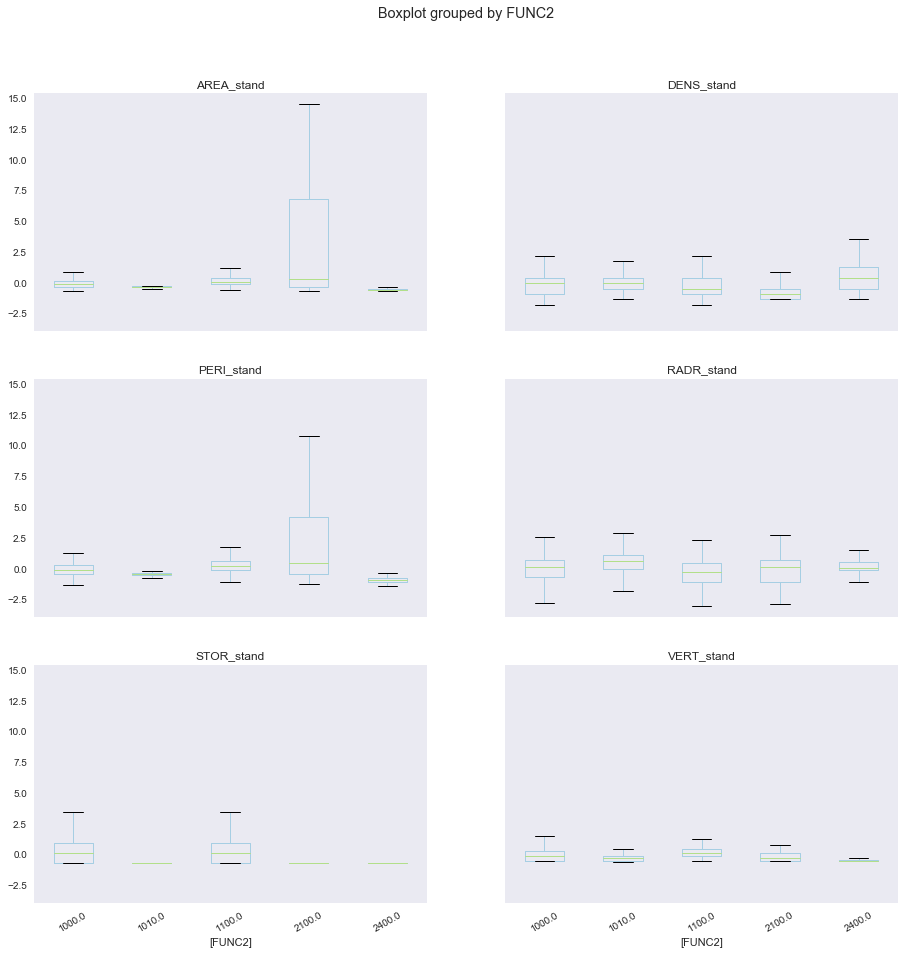

In [407]:
#https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.boxplot.html#pandas.DataFrame.boxplot
sns.set(style="white")
boxplot_geom = geom2.boxplot(by='FUNC2', figsize=(15,15), grid=False, showfliers=False, rot=30)

### we could check here if the means (or medians) are significantly different?
- whitney mann test for ranked data (density and storey): Mann-Whitney U is significant if the u-obtained is LESS THAN or equal to the critical value of U.

The Pearson's correlation coefficient measures the amount of linear dependence between two vectors. That is, it essentially lays a straight line through the scatterplot and calculates its slope. This will of course change if you take logs!

If you are interested in a measure of correlation that is invariant under monotone transformations like the logarithm, use Kendall's rank correlation or Spearman's rank correlation. These only work on <b> ranks </b>, which do not change under monotone (increasing, strictly increasing, decreasing, strictly decreasing) transformations.

examples where both correlations work: age - bloodpressure

### Strength of association and correlations

#pearson correlation. both, spearman and pearson work:
- pearson tried to make the line of best fit depicts linear relationships
- spearman ranks the values. It assesses how well the relationship between two variables can be described using a monotonic function.

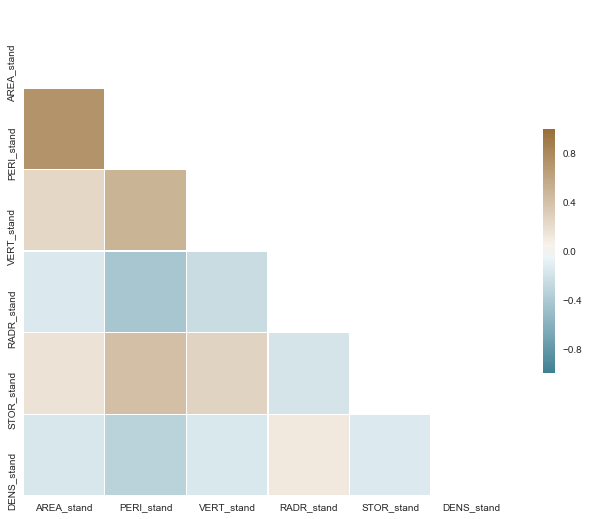

In [355]:
sns.set(style="white")

# Generate a large random dataset
#rs = np.random.RandomState(33)
#d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 #columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = geom2.corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 50, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1,center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [36]:
from pandas.plotting import scatter_matrix

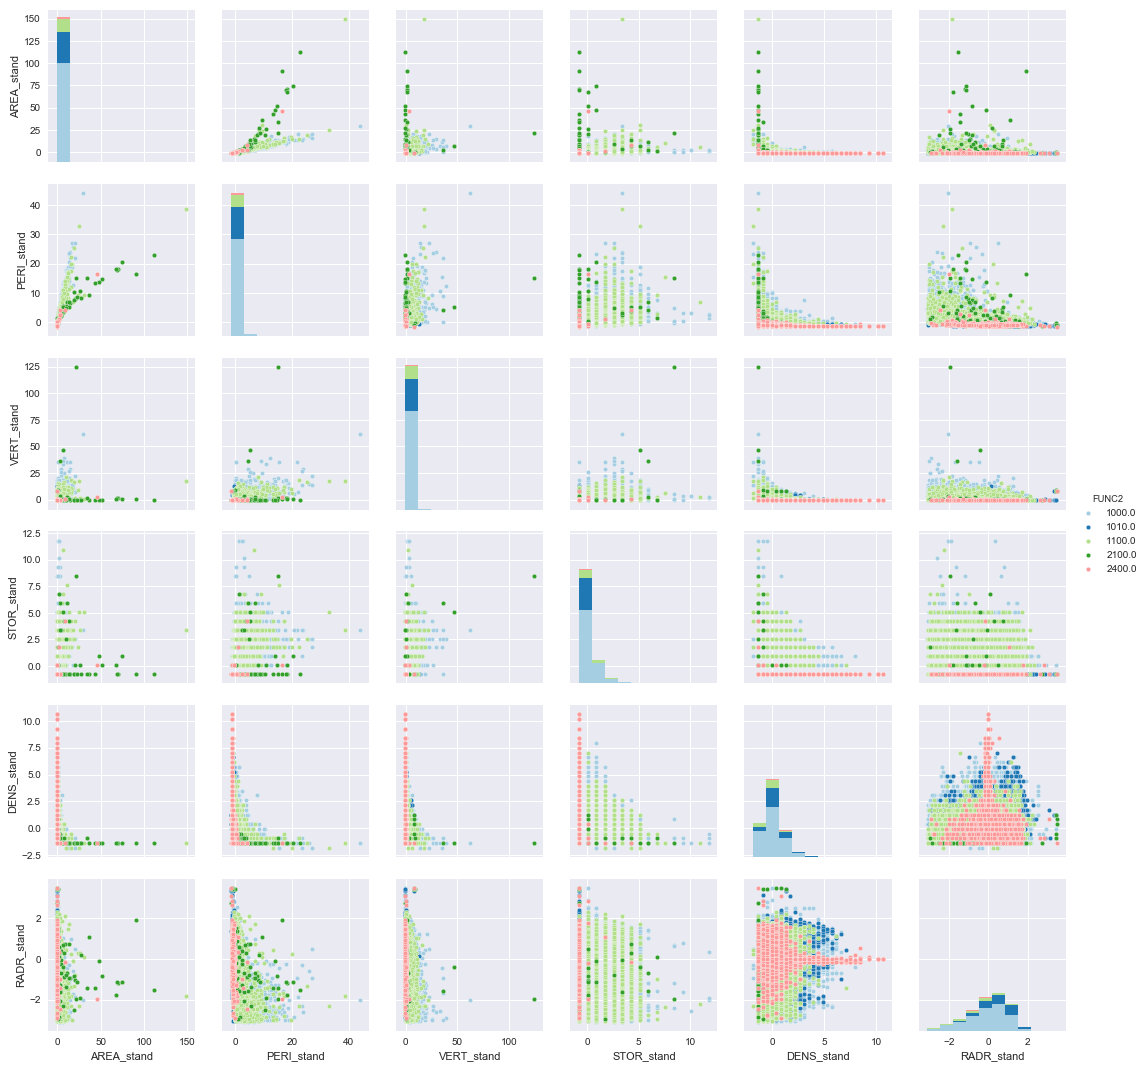

In [408]:
#fig2 =plt.fig(figsize=(15,15))
#sns.set(style="darkgrid", palette="Paired")
g = sns.pairplot(geom2, vars=["AREA_stand", "PERI_stand", "VERT_stand", "STOR_stand", "DENS_stand", "RADR_stand"], hue="FUNC2",plot_kws={"s": 20})

### about the relationship between the the featureclasses

what we can see:
    -the larger the form becomes, the more compact - there is a relationship!
    -also, the variables are heteroscedastic (different variablities in subpopulations)
    
    -vertices seem not to be associated with area or perimeter
    
    -we might have to take out variables that have some association, as they do not contribute new information to the model
    - the smaller the area, the less complexity?

### about the relationship with our predictor 'building function'

- Infrastructure buildings are all over the place: that's because they include anything from garage to train station
- Industrial buildings are less complex with larger size than residential buildings
- Single family homes tend to cluster be more 'square' (RADR)
- Interestingly, it seems like the Resi general and Single Family residences are located in denser areas than infraststructure objects and Mixed Use and Commercial (probably has to do with the definition of 'density')

### 3.2.2) Categorical and ordinal data : Year built, construction type and rooftype

### Year built

We will exclude buildings that presumably were built in the future. Hamburgs history dates back to the 8th century. The name „Hammaburg“ appeared first around the year 832 after Christ. We will therefore exclude values that are below 800.

In [410]:
#buildings_agg.YEAR.value_counts()

In [411]:
z = buildings_agg.loc[:,['YEAR', 'FUNC2']]

z = z[(z.YEAR != 0)] 
z = z[(z.YEAR > 800)]
z = z[(z.YEAR < 2018)]
z

,YEAR,FUNC2
4,2015,1000.000
5,1987,1000.000
11,2009,1010.000
12,2014,1010.000
13,1933,1000.000
16,1978,1000.000
24,2011,1000.000
26,1995,1000.000
27,2012,1000.000
28,2013,1000.000


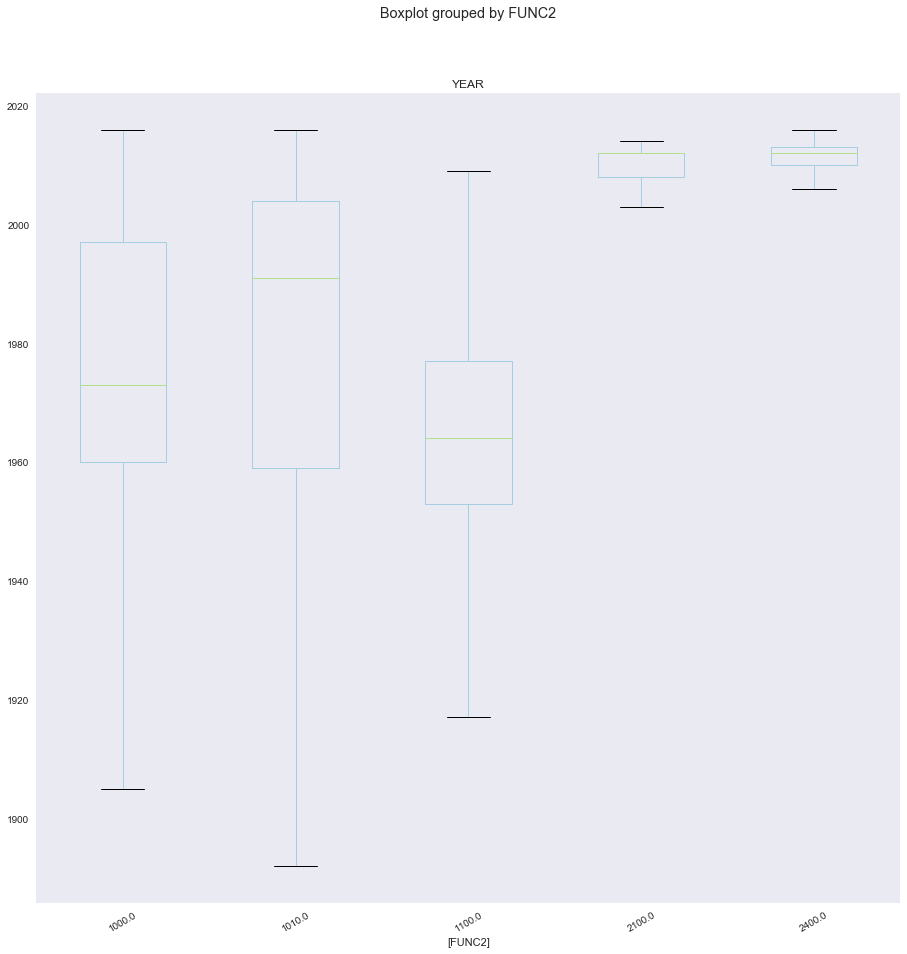

In [606]:
sns.set(style="white")
z.boxplot(by='FUNC2', figsize=(15,15), grid=False, showfliers=False, rot=30)

In [413]:
j = pd.DataFrame(z.groupby(['YEAR','FUNC2']).size())
y = j.unstack()


In [ ]:
colors = plt.cm.summer(np.linspace(0, 1, 11))
y.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors, rot=45)

The unrealistic years also have to be excluded from the main dataset:

In [427]:
#buildings_agg = buildings_agg [(buildings_agg .YEAR != 0)] 
buildings_agg  = buildings_agg [(buildings_agg.YEAR > 800)]
buildings_agg  = buildings_agg [(buildings_agg.YEAR < 2018)]

In [428]:
len(buildings_agg)

73040

### Rooftype / construction

In [709]:
def draw_stackedbar_norm(data, title, labels, sub):
    x = data.div(data.sum(axis=1), axis=0)
    colors1 = plt.cm.summer(np.linspace(0, 1, sub))
    ax = x.plot(kind='bar', stacked=True, figsize=(20, 10), color=colors1, fontsize=15, title=title)
    ax.set_xticklabels(labels, rotation=45)
    ax.legend(loc=4)

In [273]:
cat = pd.Categorical(buildings_agg.ROOF)
cat.describe()

,counts,freqs
categories,,
1000.000,27733,0.145
2100.000,1204,0.006
2200.000,57,0.000
3100.000,105369,0.552
3200.000,35002,0.183
3300.000,480,0.003
3400.000,13609,0.071
3500.000,458,0.002
3600.000,3,0.000


In [711]:
roof = buildings_agg.loc[:,['ROOF', 'FUNC2']]

In [712]:
roof1 = pd.DataFrame(roof.groupby(['FUNC2', 'ROOF']).size().unstack())

In [713]:
roof1

ROOF,1000.0,2100.0,2200.0,3100.0,3200.0,3300.0,3400.0,3500.0,3600.0,3700.0,3800.0,3900.0,4000.0,5000.0,9999.0
FUNC2,,,,,,,,,,,,,,,
1000.000,10696.000,737.000,27.000,24941.000,9006.000,87.000,5189.000,272.000,1.000,9.000,12.000,3.000,215.000,913.000,826.000
1010.000,218.000,28.000,1.000,7897.000,3580.000,230.000,513.000,53.000,nan,1.000,1.000,nan,41.000,96.000,66.000
1100.000,1023.000,nan,nan,2309.000,1049.000,nan,1504.000,nan,nan,nan,nan,nan,10.000,194.000,48.000
2100.000,29.000,nan,nan,3.000,1.000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2400.000,1051.000,22.000,2.000,68.000,49.000,2.000,1.000,9.000,nan,nan,1.000,1.000,nan,4.000,1.000


In [716]:
D = ['Residential Apartment Building','Residential Single Family','Residential Mixed Use','Commerical Industrial',
     'Infrastructure']

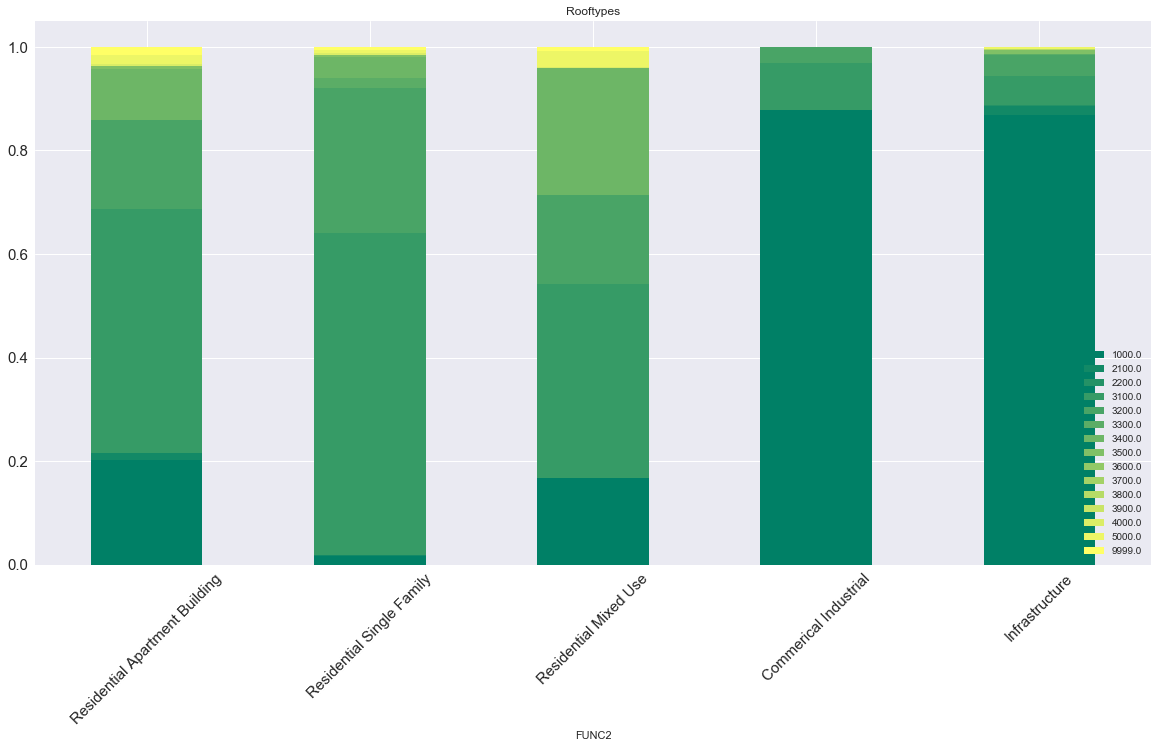

In [722]:
draw_stackedbar_norm(roof1, 'Rooftypes', D, 15)

In [269]:
construction = buildings_agg.loc[:,['CONS', 'FUNC2']]

In [261]:
buildings_agg.CONS.value_counts()

1100.000    79220
2200.000    38008
2100.000    26734
2500.000    19480
2400.000    15496
1200.000    10005
1300.000     1399
1400.000      284
0.000         164
1500.000       68
Name: CONS, dtype: int64

In [270]:
construction = pd.DataFrame(construction.groupby(['FUNC2', 'CONS']).size().unstack())
construction

CONS,0.0,1100.0,1200.0,1300.0,1400.0,1500.0,2100.0,2200.0,2400.0,2500.0
FUNC2,,,,,,,,,,
1000.000,nan,46671.000,8737.000,nan,nan,nan,12330.000,33009.000,11753.000,17857.000
1010.000,nan,23724.000,38.000,1.000,1.000,nan,13554.000,4308.000,35.000,14.000
1100.000,nan,8805.000,1230.000,nan,nan,nan,849.000,691.000,3708.000,1609.000
2000.000,36.000,nan,nan,nan,nan,nan,nan,nan,nan,nan
2100.000,112.000,nan,nan,nan,nan,nan,nan,nan,nan,nan
2400.000,16.000,20.000,nan,1398.000,283.000,68.000,1.000,nan,nan,nan


In [721]:
draw_stackedbar_norm(construction, 'Construction types', D, 10)

NameError: name 'construction' is not defined

## 3.3) Conclusions

### Deleting zero values / removing outliers / exclude rare classes
Our original dataset is now remarkably smaller.
1. Original sample size: **363'310**
2. Subset the five most frequent categories: **295'194**
3. Drop zero values expect Construction and Years: **190'822**
4. Drop unusual years: **73'040**
    
If you don't want to get rid of data, you could make zero values huge outliers -9999 but not all algorithms handle outliers equally well.

what we can see:

    -year does have an influence on number of objects built
    -we cannot see whether year has an influence on what function buildings have. How can we test this? Fisher's test on two years
    
let's definitely exclude the weird years.

In [22]:
len(buildings_agg)
#buildings_agg.YEAR.value_counts()

73045

### Note: if we exclude the column YEAR, we obtain a larger sample and preserve the classes than if we delete the missing values for years. 

In [ ]:
buildings_agg.FUNC2.value_counts()
buildings_agg

# 4) Prepare the data for classification

Before the data can be used for classification, some adjustments need to be made. The labels we aim to predict and the features we want to use for the prediction need to be separated. In addition, the two categories `ROOF` and `CONS` will need to be transformed into dummy variables to avoid them being interpreted as numerical. The transformer `OneHotEncoder()` will use a method called a binary one-hot (aka one-of-K) coding. Depending on the number of categories `n`, it will split up each value into a binary sequence of columns `n`.

1) split off the labels we aim to classify

In [696]:
labels = buildings_agg['FUNC2']
len(labels)

73040

2) split off features we base the classification on

In [467]:
#split off features we base the classification on
feat = buildings_agg.loc[:,(buildings_agg.columns != 'FUNC')& (buildings_agg.columns != 'FUNC2')]
len(feat)

73040

## 4.1) Insert dummy variables for categories

In [25]:
from sklearn.preprocessing import OneHotEncoder

In [468]:
#subset categoricals
cat = feat[['ROOF','CONS']]
feat1 = feat.loc[:,(feat.columns != 'ROOF')& (feat.columns != 'CONS')]
feat1 = feat1.reset_index(drop=True)

In [228]:
len(feat1)

73045

In [469]:
enc = OneHotEncoder()
feat_enc = enc.fit_transform(cat)

In [440]:
feat_enc

<73040x25 sparse matrix of type '<class 'numpy.float64'>'
	with 146080 stored elements in Compressed Sparse Row format>

In [470]:
feat_array = feat_enc.toarray()

In [471]:
#join data
feat1=pd.merge(feat1,pd.DataFrame(feat_array),how='outer',left_index=True,right_index=True)

In [472]:
feat1.tail()

,STOR,AREA,YEAR,PERI,VERT,CENX,CENY,DENS,RADR,0,...,15,16,17,18,19,20,21,22,23,24
73035,4.000,913.000,2006,192,37,565935,5948276,2.000,0.284,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
73036,4.000,307.000,2006,81,13,565890,5948289,3.000,0.495,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
73037,4.000,306.000,2006,81,13,565914,5948228,4.000,0.499,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
73038,3.000,228.000,2008,65,10,565956,5948186,2.000,0.510,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000
73039,1.000,82.000,1992,37,8,570719,5952023,2.000,0.649,0.000,...,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## 4.2) Feature selection with univariate statistics

It is also useful to filter through the features and reduce dimensionality for the following reasons:

1) prevent overfitting <br>
2) reduced computation time <br>
3) uncover relationships between target and features

There are plenty of methods to do this, in this case `SelectKBest()` selector using univariate statistics is used. By default, it identifies relevant features by using the one way ANOVA F-test. In this case, we will use the Chi-squared statistic since our data is not normally distributed. SelectKBest compares the input features `X` with the labels `y` and retains the first `k` features of `X` with the highest scores. A large value suggests that the feature provides important information and will therefore be kept. Will will keep all or variables, including the Year, depite the large amount of zero values as our boxplot above suggests differences between building functions. 

<b> To see if feature selection truly provides better outputs, the first classifier is run without and with reduced features.

In [234]:
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold

In [473]:
#input the encoded dataset
X, y = feat1, labels

In [474]:
#create selector, set k=8
sel=SelectKBest(chi2, k=15)

feat2 = sel.fit_transform(X, y)

In [475]:
#shows selected features
sel.get_support()

array([ True,  True, False,  True,  True,  True,  True,  True, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
        True,  True,  True,  True, False,  True,  True], dtype=bool)

The Chi2 statistic identified 11 columns as redundant. To doublecheck if the two features were removed:

In [477]:
#doublecheck if features were reduced:
feat2.shape

(73040, 15)

# 5) Multiclass Classification: k-nearest Neighbors (Supervised)

### About knN

Supervised neighbors-based classification for data with discrete, multiclass labels. Compare distance between a unlabelled point with labelled points and assign label based on shortest Euclidian distance. 'k' specifies how many nearest neigbors we want to identify for the point we want to classify. The majority class of the neighbors will be assigned. Basic parameters that can be adjusted:


| Parameters       |Inputs| What they do        |
| :-------------- |:-------------|:-------------| 
| k     |Integers| No. of neighbors to compare to | 
| weights        |uniform, distance, callable | Weighs neigbors uniformly, based on inverse distance weighting or custom |  
| algorithm      |BallTree, KDTree, Brute, Auto| Different algorithms for searching neighbors| 

on crossvalidation: http://scikit-learn.org/stable/modules/cross_validation.html

on choosing the right algorithm: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

good tutorial: https://www.oreilly.com/ideas/intro-to-scikit-learn

## 5.1) Initial test runs

In [36]:
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [478]:
#without feature selection
train_d, test_d, train_lab, test_lab = train_test_split(feat1, labels)

In [479]:
#with feature selection
train_d_fs, test_d_fs, train_lab_fs, test_lab_fs = train_test_split(feat2, labels)

In [480]:
train_d.shape,test_d.shape

((54780, 34), (18260, 34))

In [481]:
train_d_fs.shape,test_d_fs.shape

((54780, 15), (18260, 15))

In [482]:
#without feature selection
knn1 = KNeighborsClassifier(n_neighbors=5)  # creates the kNN classifier, setting it to check the 60 neighbouring points
a = time.time()
knn1.fit(train_d, train_lab)  # executes the classifier on the training dataset

elapsed = time.time()- a
print(knn1,'takes', elapsed, 'seconds to run')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') takes 0.18822288513183594 seconds to run


In [483]:
#with feature selection
knn2 = KNeighborsClassifier(n_neighbors=5)  # creates the kNN classifier, setting it to check the 60 neighbouring points
a = time.time()
knn2.fit(train_d_fs, train_lab_fs)  # executes the classifier on the training dataset

elapsed = time.time()- a
print(knn2,'takes', elapsed, 'seconds to run')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform') takes 0.09184002876281738 seconds to run


mean accuracy score:

In [484]:
knn1.score(test_d, test_lab),knn2.score(test_d_fs, test_lab_fs)

(0.78707557502738223, 0.79194961664841179)

The mean accuracy score is a very imprecise measure. To get a better sense of how well the classifier performed we will look at the detailed summary statistics. In order to obtain the full information, the trained classifier is applied on our test dataset.

In [485]:
knn1_lab_pred = knn1.predict(test_d)
knn2_lab_pred = knn2.predict(test_d_fs)

### Classification_report: the metrics explained


| Parameters       |What they explain |
| :-------------- |:-------------|
| recall     |tp / (tp + fn): correctly labelled (tp) / total labels of that class (tp + fn)| 
| precision  |tp / (tp + fp): lower precision when predictions are scattered |  
| f1-score   |weighted harmonic mean of precision and recall| 
| support   |Number of occurrences of each class in the correct target values (test_lab)| 

KnN <b> without </b> feature selection:

In [486]:
knn1_cm = metrics.confusion_matrix(test_lab, knn1_lab_pred)
print(metrics.classification_report(test_lab, knn1_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.82      0.91      0.87     13171
     1010.0       0.66      0.62      0.64      3230
     1100.0       0.44      0.16      0.23      1541
     2100.0       0.80      1.00      0.89         8
     2400.0       0.94      0.32      0.48       310

avg / total       0.77      0.79      0.77     18260



KnN <b> with </b> feature selection:

In [487]:
knn2_cm = metrics.confusion_matrix(test_lab_fs, knn2_lab_pred)
print(metrics.classification_report(test_lab_fs, knn2_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.83      0.91      0.87     13350
     1010.0       0.66      0.63      0.64      3123
     1100.0       0.41      0.15      0.23      1497
     2100.0       0.90      1.00      0.95         9
     2400.0       0.93      0.31      0.46       281

avg / total       0.77      0.79      0.77     18260



Depending on the subdivision of test and traindata we might get a warning here stating that 'Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples'. This warning refers to our class 2000 (Commerical Retail & Office) where there are only 2 occurences in our test data. With only 36 objects in the entire dataset this might not be a sufficiently large sample for classification.

### The confusion matrix

The confusion matrix, also known as an error matrix, is a 2d array that visualizes of the performance of an algorithm. The sum of each row returns the actual number of occurences in each class and the sum of the colum returns what the total of what the classifer predicted.

In [488]:
#knN without feature selection
knn1_cm

array([[12011,   858,   298,     0,     4],
       [ 1211,  2013,     4,     0,     2],
       [ 1229,    71,   241,     0,     0],
       [    0,     0,     0,     8,     0],
       [  119,    90,     0,     2,    99]])

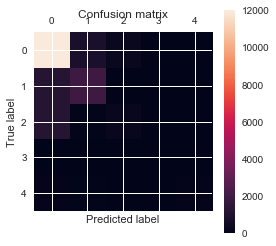

In [489]:
plt.matshow(knn1_cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

The visualisation is not very informative because our sample contains much more predictions in the first column. A way to ease this is to normalize our 2D array. In that way, we visualize the predictions relative to the class size.

In [490]:
def norm_cm(matrix):
    row_sums = matrix.sum(axis=1) # array([ 9, 36, 63])
    new_matrix = np.zeros((5,5))
    for i, (row, row_sum) in enumerate(zip(matrix, row_sums)):
        new_matrix[i,:] = row / row_sum
    return new_matrix

In [193]:
norm_cm(knn1_cm)

array([[  9.15519732e-01,   6.13641548e-02,   2.28119535e-02,
          0.00000000e+00,   0.00000000e+00,   3.04159380e-04],
       [  3.65591398e-01,   6.31336406e-01,   1.22887865e-03,
          0.00000000e+00,   0.00000000e+00,   1.84331797e-03],
       [  7.94520548e-01,   3.97912590e-02,   1.65688193e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.81818182e-01,   8.18181818e-01,   0.00000000e+00],
       [  3.98713826e-01,   2.34726688e-01,   0.00000000e+00,
          3.21543408e-03,   3.21543408e-03,   3.60128617e-01]])

In [732]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def make_cms(cm1,cm2,tit1,tit2,lab):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,9))
    ax1.set_title(tit1)
    # Display image, `aspect='auto'` makes it fill the whole `axes` (ax3)
    im1 = ax1.imshow(norm_cm(cm1))
    # Create divider for existing axes instance
    divider1 = make_axes_locatable(ax1)
    # Append axes to the right of ax3, with 20% width of ax3
    cax1 = divider1.append_axes("right", size="10%", pad=0.1)
    cbar1 = plt.colorbar(im1, cax1)

    ax1.set_yticklabels(lab)
    ax1.set_xticklabels(lab)

    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')

    ax2.set_title(tit2)
    im2 = ax2.imshow(norm_cm(cm2))
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="10%", pad=0.1)
    cbar2 = plt.colorbar(im2, cax=cax2)

    ax2.set_yticklabels(lab)
    ax2.set_xticklabels(lab)

    plt.show()

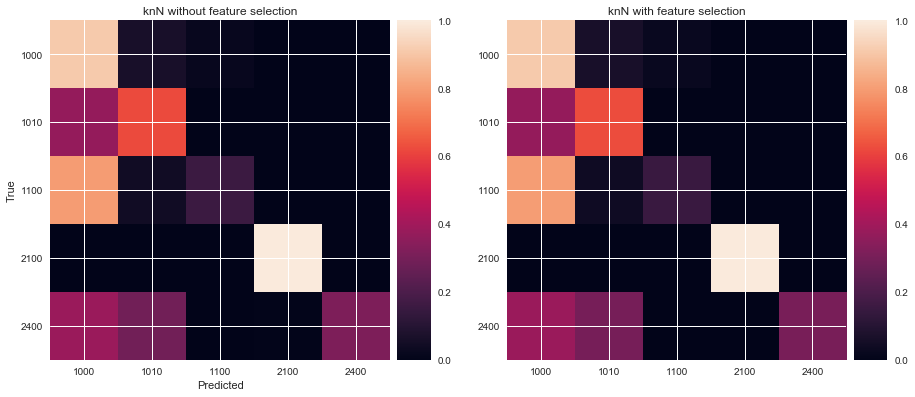

In [733]:
labelsCM = ['A','1000','1010','1100', '2100','2400']
make_cms(knn1_cm,knn2_cm,'knN without feature selection','knN with feature selection',labelsCM)

## 5.2) Initial results knN

### 1000: Residential Apartment Building: 
is biased between mixed use and single family

### 1010: Residential Single Family: 
biased between multi and mixed use

### 1100: Residential Mixed Use: 
is difficult to predict, too similar to residential multi?

### 2000: Commerical Retail & Office: 
is being prediced as industrial

### 2100: Commerical Industrial: 
is being well predicted, despite the little sample

### 2400: Infrastructure: 
is difficult to predict, as many of its features have a high variance


conclusion: classification is biased towards overrepresented sample and trends to struggle in classifing uses that all relate to residential purposes. 
We can see that algorithm is biased towards label 0 ( = 1000, which is the most prevalent). Aggregating labels and decreasing the overrepresented label only helped minorly.

## 5.3) Implementing Gridsearch for KnN

Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. The process of finding the right parameters can be automatized with Gridsearch(). It runs over a set of parameters at once and finds the optimal settings. 


| Parameters       |Inputs| 
| :-------------- |:-------------|
| Classifier   |The classifier we want to test| 
| Parameters   |Parameters a given classifier requires |   
| cv   | takes the train dataset and splits it up in train and test for x consecutive times|

In [11]:
from sklearn.model_selection import GridSearchCV

Set the parameters to interate through: <br>
<b> 4 n_neighbors x 2 weights = 6 combinations x 5 consecutive runs

In [492]:
parameters = {'n_neighbors': [5,10,20,30], 'weights':['distance','uniform'],'algorithm': ['auto'] }

In [495]:
knn1_grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=2, scoring='accuracy')
knn2_grid_search = GridSearchCV(KNeighborsClassifier(), parameters, cv=2, scoring='accuracy')

In [501]:
#without feature selection
a = time.time()
knn1_grid_search.fit(train_d,train_lab)
elapsed = time.time()- a
print(knn1_grid_search, 'takes', elapsed, 'seconds to run')

GridSearchCV(cv=2, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 10, 20, 30], 'weights': ['distance', 'uniform'], 'algorithm': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0) takes 31.524220943450928 seconds to run


In [496]:
#with feature selection
a = time.time()
knn2_grid_search.fit(train_d_fs,train_lab_fs)
elapsed = time.time()- a
print(knn2_grid_search,'takes', elapsed, 'seconds to run')

GridSearchCV(cv=2, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 10, 20, 30], 'weights': ['distance', 'uniform'], 'algorithm': ['auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0) takes 14.37749195098877 seconds to run


In [833]:
#results from all 5 runs
results = knn2_grid_search.cv_results_

In [497]:
# takes the parameter with the best mean test score
knn2_grid_search.best_params_

{'algorithm': 'auto', 'n_neighbors': 20, 'weights': 'distance'}

In [502]:
knn1_grid_search.score(test_d, test_lab), knn2_grid_search.score(test_d_fs, test_lab_fs)

(0.8048740416210296, 0.8095290251916758)

In [822]:
# takes the parameter with the best mean test score
knn_grid_search2.best_params_

{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'distance'}

In [503]:
knn1_gs_lab_pred = knn1_grid_search.predict(test_d)

In [505]:
knn2_gs_lab_pred  = knn2_grid_search.predict(test_d_fs)

In [506]:
print(metrics.classification_report(test_lab, knn1_gs_lab_pred ))

             precision    recall  f1-score   support

     1000.0       0.83      0.93      0.88     13171
     1010.0       0.70      0.68      0.69      3230
     1100.0       0.47      0.13      0.20      1541
     2100.0       0.80      1.00      0.89         8
     2400.0       0.98      0.38      0.55       310

avg / total       0.78      0.80      0.78     18260



In [507]:
print(metrics.classification_report(test_lab_fs, knn2_gs_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.83      0.94      0.88     13350
     1010.0       0.71      0.63      0.67      3123
     1100.0       0.54      0.10      0.18      1497
     2100.0       0.89      0.89      0.89         9
     2400.0       0.95      0.34      0.50       281

avg / total       0.79      0.81      0.78     18260



In [511]:
knn1_gs_cm = metrics.confusion_matrix(test_lab, knn1_gs_lab_pred)
knn2_gs_cm = metrics.confusion_matrix(test_lab, knn2_gs_lab_pred)

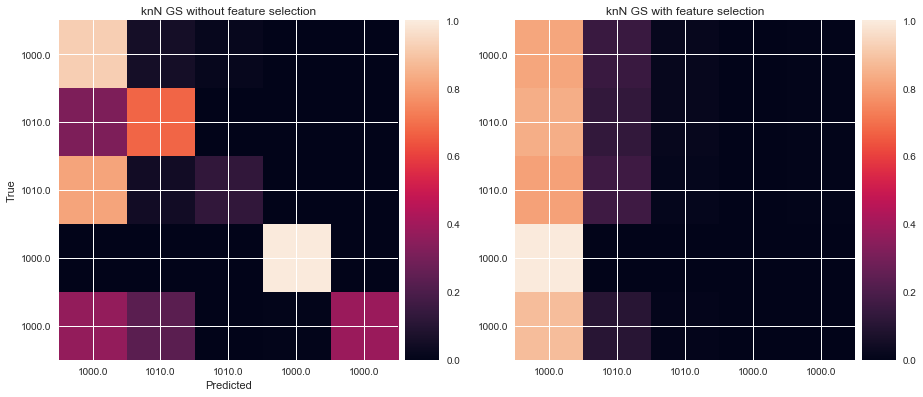

In [534]:
make_cms(knn1_gs_cm,knn2_gs_cm,'knN GS without feature selection','knN GS with feature selection',labelsCM)

# 6) Decision tree classifier

### About the classifier

Decision trees split features into subgroups (e.g. the feature 'gender' into 'female' and 'male'). Out of these subgroups they choose the feature with the most homogenous subgroup, that is, the subgroup that splits our target best as the inital split rule. The process continues until no more useful splits can be found. Classification is able to predict binary labels as well as multiclass labels. It is important to keep in mind that when working with continuous numerical variables, a decision tree looses information when it categorizes variables in different categories. Some parameters explained:


| Parameters       |Inputs| What they do        |
| :-------------- |:-------------|:-------------| 
| criterion     |gini, entropy| By default 'gini'. Measures the quality, i.e. the homogenity of the subgroups. Gini index = 0: all records in the node belong to the same category. | 
| splitter        |best, random | The strategy used to choose the split at each node |  
| max_depth     |integer| The 'depth' of the tree: in how many subgroups each feature is split| 
| min_samples_split  |integer or float (for %)| The minimum number of samples required to split an internal node| 


## 6.1) Initial test runs

In [4]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [7]:
import graphviz

In [513]:
dtree = DecisionTreeClassifier(random_state=0, max_depth=2)
dtree.fit(train_d, train_lab)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [514]:
dtree.score(test_d, test_lab)

0.89819277108433737

In [530]:
test_d.shape
test_d.columns

Index(['STOR', 'AREA', 'YEAR', 'PERI', 'VERT', 'CENX', 'CENY', 'DENS', 'RADR',
            0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,     10,     11,     12,     13,     14,     15,     16,     17,
           18,     19,     20,     21,     22,     23,     24],
      dtype='object')

In [560]:
lab_dec =['1000','1010','1100','2100','2400']

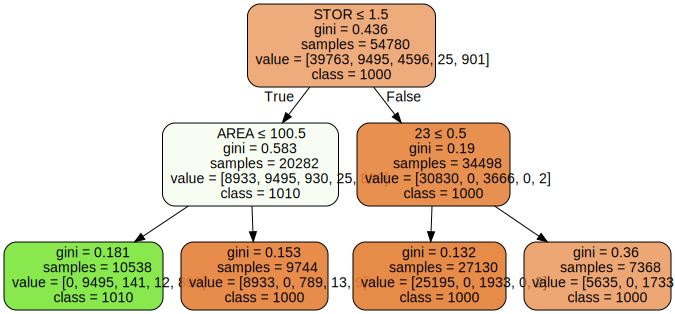

In [561]:
dot_data = export_graphviz(dtree, out_file=None, 
                         feature_names=feat1.columns,  
                         class_names=lab_dec,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

With a depth of 2, the Decision Tree Classifier suggests that the features 'STOR' (x[0]) , Area (x[1]) and a column from our encoded dummy variables (x[32]) provide the best split into homogenous functional groups. We can see in the classification matrix below that the classifier currently only predicts buildings of type 1000 and 1010.

In [597]:
dtree1_lab_pred = dtree.predict(test_d)

In [598]:
print(metrics.classification_report(test_lab, dtree1_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.90      1.00      0.95     13171
     1010.0       0.90      1.00      0.95      3230
     1100.0       0.00      0.00      0.00      1541
     2100.0       0.00      0.00      0.00         8
     2400.0       0.00      0.00      0.00       310

avg / total       0.81      0.90      0.85     18260



/Users/myveryself/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [599]:
dtree1_cm=metrics.confusion_matrix(test_lab, dtree1_lab_pred)
dtree1_cm

array([[13171,     0,     0,     0,     0],
       [    0,  3230,     0,     0,     0],
       [ 1494,    47,     0,     0,     0],
       [    5,     3,     0,     0,     0],
       [    8,   302,     0,     0,     0]])

## 6.2) Implementing Gridsearch CV and pipelining for Decision Trees

The sklearn.pipeline module chains transformations (such as feature selection) hyperparametrization and classifiers.

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.pipeline import make_pipeline

In [585]:
dtree_pipe = make_pipeline(VarianceThreshold(), DecisionTreeClassifier())
dtree_params = {'decisiontreeclassifier__max_features' : [25, 30, 33, 'auto'],
             'decisiontreeclassifier__max_depth' : [3,4,5, None]}
dtree_grid_search = GridSearchCV(dtree_pipe, dtree_params, cv=3, scoring='accuracy', verbose=2)

In [586]:
a = time.time()
dtree_grid_search.fit(train_d, train_lab)
elapsed = time.time()- a
print(dtree_grid_search,'takes', elapsed, 'seconds to run')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=25, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=30 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=30, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=30 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=30, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=30 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=30, total=   0.1s
[CV] decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=33 
[CV]  decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=33, total=   0.

[CV]  decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_features=auto, total=   0.1s
[CV] decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_features=auto 
[CV]  decisiontreeclassifier__max_depth=None, decisiontreeclassifier__max_features=auto, total=   0.1s


[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    8.7s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'decisiontreeclassifier__max_features': [25, 30, 33, 'auto'], 'decisiontreeclassifier__max_depth': [3, 4, 5, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2) takes 8.88728404045105 seconds to run


In [587]:
dtree_grid_search.score(test_d, test_lab)

0.91467688937568459

In [588]:
dtree_grid_search.best_params_

{'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__max_features': 33}

In [671]:
dtree2_lab_pred=dtree_grid_search.predict(test_d)

In [672]:
print(metrics.classification_report(test_lab, dtree2_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.90      1.00      0.95     13171
     1010.0       0.98      1.00      0.99      3230
     1100.0       0.48      0.02      0.04      1541
     2100.0       1.00      0.50      0.67         8
     2400.0       0.99      0.97      0.98       310

avg / total       0.88      0.91      0.88     18260



In [673]:
dtree2_cm = metrics.confusion_matrix(test_lab, dtree2_lab_pred)

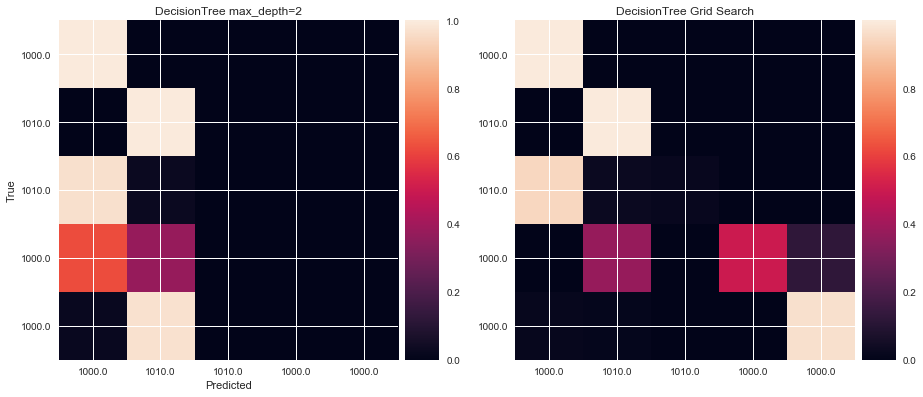

In [725]:
make_cms(dtree1_cm,dtree2_cm,'DecisionTree max_depth=2','DecisionTree Grid Search',labelsCM)

# 7) Random Forest classifier

In [603]:
rf_pipe = make_pipeline(VarianceThreshold(), RandomForestClassifier(n_jobs=-1))
rf_params = {'randomforestclassifier__n_estimators' : [70, 80, 100],
             'randomforestclassifier__max_features' : [20, 15, 30, 'auto'],
             'randomforestclassifier__max_depth' : [5, 10, None]}
rf_grid_search = GridSearchCV(rf_pipe, rf_params, cv=3, scoring='accuracy', verbose=2)

In [604]:
rf_grid_search.fit(train_d, train_lab)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100, total=   2.6s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100, total=   2.4s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=100, total=   2.5s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=120 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=120, total=   2.8s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=120 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=20, randomforestclassifier__n_estimators=120, total=   2.9s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier_

[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=120, total=   1.3s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=140 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=140, total=   1.6s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=140 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=140, total=   1.5s
[CV] randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=140 
[CV]  randomforestclassifier__max_depth=5, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=140, total=   1.5s
[CV] randomforestclassifier__max_depth=10, randomfo

[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100, total=   1.7s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100, total=   1.9s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=100, total=   1.8s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=120 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=120, total=   1.9s
[CV] randomforestclassifier__max_depth=10, r

[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=120, total=   9.9s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=120 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=120, total=  10.0s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=140 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=140, total=  12.8s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=140 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__max_features=30, randomforestclassifier__n_estimators=140, total=  12.0s
[CV] randomforestclassifier__max_depth=None,

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:  9.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [100, 120, 140], 'randomforestclassifier__max_features': [20, 15, 30, 'auto'], 'randomforestclassifier__max_depth': [5, 10, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [609]:
rf_grid_search.best_params_

{'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 15,
 'randomforestclassifier__n_estimators': 100}

In [610]:
rf_grid_search.score(test_d, test_lab)

0.91686746987951806

In [678]:
rf_lab_pred = rf_grid_search.predict(test_d)

In [679]:
print(metrics.classification_report(test_lab, rf_lab_pred))

             precision    recall  f1-score   support

     1000.0       0.91      0.99      0.95     13171
     1010.0       0.99      1.00      0.99      3230
     1100.0       0.56      0.10      0.17      1541
     2100.0       0.78      0.88      0.82         8
     2400.0       0.99      0.98      0.99       310

avg / total       0.89      0.92      0.89     18260



In [680]:
rf_cm=metrics.confusion_matrix(test_lab, rf_lab_pred)

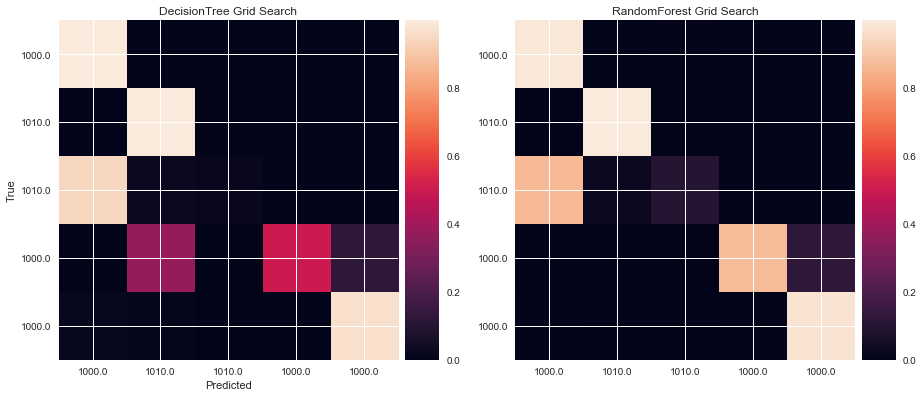

In [617]:
make_cms(dtree2_cm,rf_cm, 'DecisionTree Grid Search','RandomForest Grid Search',labelsCM)

In [345]:
print(metrics.classification_report(test_lab2, pred_dtree))

             precision    recall  f1-score   support

     1000.0       0.90      0.99      0.94     32557
     1010.0       0.97      0.99      0.98     10512
     1100.0       0.35      0.03      0.05      4143
     2000.0       0.00      0.00      0.00        12
     2100.0       0.44      0.24      0.31        34
     2400.0       0.82      0.78      0.80       457

avg / total       0.86      0.91      0.87     47715



# 7) Key findings

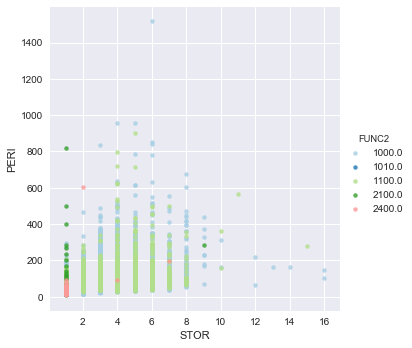

In [629]:
sns.lmplot('STOR', # Horizontal axis
           'PERI', # Vertical axis
           data=buildings_agg, # Data source
           fit_reg=False, # Don't fix a regression line
           hue="FUNC2",
           #ax=ax1,# Set color
           scatter_kws={"marker": "D", # Set marker style
                        "s": 20})  # S marker size

In [660]:
test_reindexed = test_d.reset_index(drop=True)

In [687]:
knn1_out = pd.merge(test_reindexed, pd.DataFrame(knn1_lab_pred),how='outer',left_index=True,right_index=True)
knn1_out.rename(columns={'0_y':'FUNC'}, inplace=True)
knn1_out=knn1_out[['STOR','PERI','FUNC']]

In [675]:
knn2_out = pd.merge(test_reindexed, pd.DataFrame(knn2_lab_pred),how='outer',left_index=True,right_index=True)
knn2_out=knn_out[['STOR','PERI','0_y']]

In [676]:
dtree_out = pd.merge(test_reindexed, pd.DataFrame(dtree2_lab_pred),how='outer',left_index=True,right_index=True)
dtree_out=knn_out[['STOR','PERI','0_y']]

In [681]:
rf_out = pd.merge(test_reindexed, pd.DataFrame(rf_lab_pred),how='outer',left_index=True,right_index=True)
rf_out=knn_out[['STOR','PERI','0_y']]

In [683]:
knn1_out['0_y']

0       1000.000
1       1000.000
2       1010.000
3       1000.000
4       1000.000
5       1000.000
6       1000.000
7       1010.000
8       1000.000
9       1000.000
10      1010.000
11      1000.000
12      1000.000
13      1000.000
14      1010.000
15      1000.000
16      1000.000
17      1000.000
18      1000.000
19      1000.000
20      1000.000
21      1010.000
22      1000.000
23      1000.000
24      1010.000
25      1000.000
26      1010.000
27      1000.000
28      1000.000
29      1010.000
30      1000.000
31      1000.000
32      1000.000
33      1000.000
34      1000.000
35      1000.000
36      1000.000
37      1000.000
38      1000.000
39      1000.000
40      1000.000
41      1000.000
42      1000.000
43      1000.000
44      1010.000
45      1010.000
46      1000.000
47      1000.000
48      1000.000
49      1000.000
50      1000.000
51      1000.000
52      1000.000
53      1000.000
54      1000.000
55      1010.000
56      1000.000
57      1000.000
58      1000.0

In [646]:
len(knn1_lab_pred)

18260

In [647]:
len(test_d)

18260

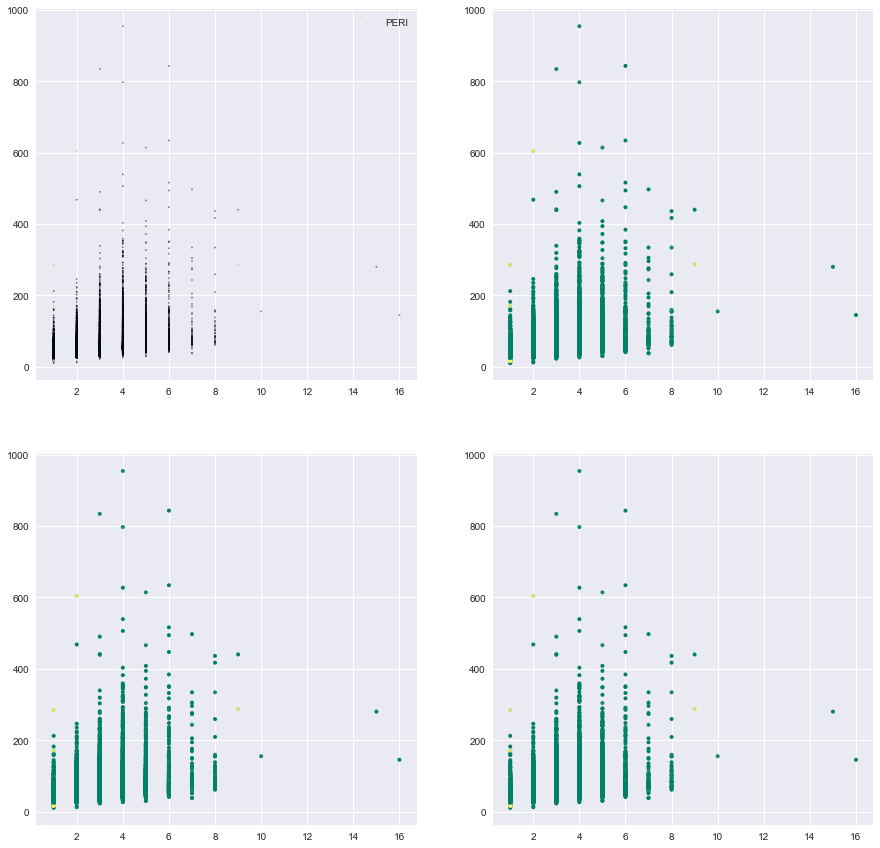

In [738]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,15))
ax1.scatter(x=knn1_out.STOR, y=knn1_out.PERI, s=2, c=knn1_out.FUNC, alpha=0.5)
ax2.scatter(knn2_out.STOR, knn2_out.PERI, s=4, linewidths=2, c=knn2_out['0_y'], cmap=plt.cm.summer)
ax3.scatter(dtree_out.STOR, dtree_out.PERI, s=4, linewidths=2, c=dtree_out['0_y'], cmap=plt.cm.summer)
ax4.scatter(rf_out.STOR, rf_out.PERI, s=4, linewidths=2, c=rf_out['0_y'], cmap=plt.cm.summer)
ax1.legend()
plt.show()

In [694]:
from sklearn.metrics import precision_recall_fscore_support

In [704]:
def results_df(test, pred, labs):
    precision, recall, f_score, support = precision_recall_fscore_support(test,pred,labels=labs,average=None)
    results_pd = pd.DataFrame({"class": labels,
                               "precision": precision,
                               "recall": recall,
                               "f_score": f_score,
                               "support": support
                               })
    results_pd = results_pd.drop_duplicates(keep='first')
    results_pd =results_pd.reset_index(drop=True)
    return(results_pd)

### k-nearest Neighbors Classifier inital test run

In [705]:
results_df(test_lab,knn1_lab_pred,labels)

,class,f_score,precision,recall,support
0,1000.000,0.866,0.824,0.912,13171
1,1010.000,0.643,0.664,0.623,3230
2,1100.000,0.231,0.444,0.156,1541
3,2400.000,0.477,0.943,0.319,310
4,2100.000,0.889,0.800,1.000,8


### k-nearest Neighbors Classifier Grid Search

In [740]:
results_df(test_lab,knn1_gs_lab_pred,labels)

,class,f_score,precision,recall,support
0,1000.000,0.878,0.835,0.925,13171
1,1010.000,0.690,0.704,0.676,3230
2,1100.000,0.204,0.467,0.130,1541
3,2400.000,0.552,0.983,0.384,310
4,2100.000,0.889,0.800,1.000,8


### Decision Tree Classifier Grid Search

In [707]:
results_df(test_lab,dtree2_lab_pred,labels)

,class,f_score,precision,recall,support
0,1000.000,0.946,0.900,0.997,13171
1,1010.000,0.992,0.984,1.000,3230
2,1100.000,0.045,0.480,0.023,1541
3,2400.000,0.982,0.993,0.971,310
4,2100.000,0.667,1.000,0.500,8


### Random Forest Classifier Grid Search

In [708]:
results_df(test_lab,rf_lab_pred,labels)

,class,f_score,precision,recall,support
0,1000.000,0.947,0.907,0.991,13171
1,1010.000,0.992,0.985,1.000,3230
2,1100.000,0.167,0.557,0.098,1541
3,2400.000,0.987,0.993,0.981,310
4,2100.000,0.824,0.778,0.875,8


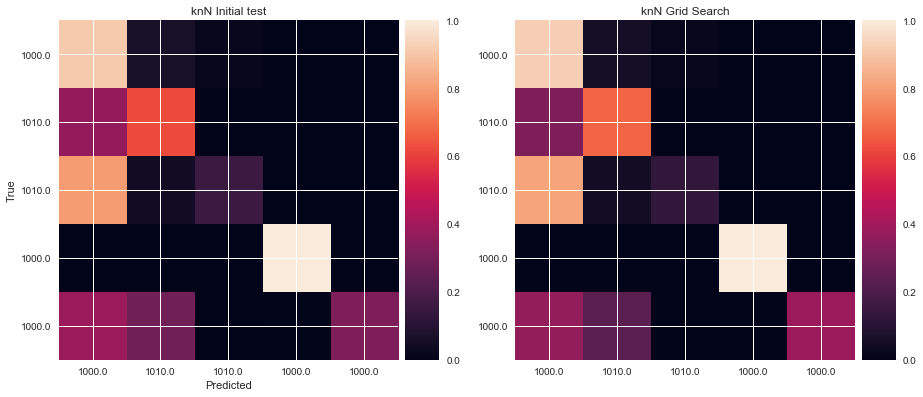

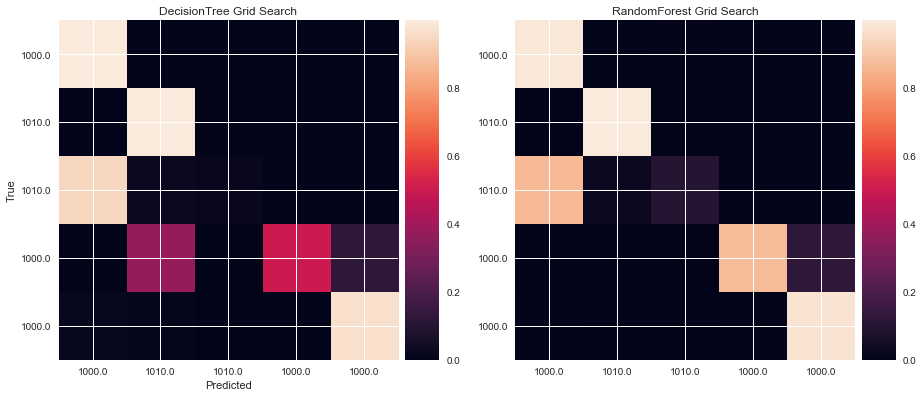

In [728]:
make_cms(knn1_cm,knn1_gs_cm, 'knN: initial test run','knN: Grid Search',labelsCM)
make_cms(dtree2_cm,rf_cm, 'DecisionTree: Grid Search','RandomForest: Grid Search',labelsCM)

## 5.2) Initial results knN

### 1000: Residential Apartment Building: 
Highest f-score: Random Forest <br>
Lowest f-score: k nearest Neighbors with manual feature selection

### 1010: Residential Single Family: 
Highest f-score: Random Forest
Lowest f-score: k nearest Neighbors with manual feature selection

### 1100: Residential Mixed Use: 
Highest f-score: Random Forest
Lowest f-score: k nearest Neighbors with manual feature selection

### 2000: Commerical Retail & Office: 
is being prediced as industrial

### 2100: Commerical Industrial: 
is being well predicted, despite the little sample

### 2400: Infrastructure: 
is difficult to predict, as many of its features have a high variance


conclusion: classification is biased towards overrepresented sample and trends to struggle in classifing uses that all relate to residential purposes. 
We can see that algorithm is biased towards label 0 ( = 1000, which is the most prevalent). Aggregating labels and decreasing the overrepresented label only helped minorly.

# 8) References

Wurm, M., Schmitt, A., Taubenböck, H. (2016). **Building Types’ Classification Using Shape-Based Features and Linear Discriminant Functions.** IEEE Journal of selected topics in applied earth observations and remote sensing.
https://ieeexplore.ieee.org/document/7210144/

Steiniger, S., Lange, T., Burghardt, D., Weibel, R. (2008). **An Approach for the Classification of Urban Building Structures Based on Discriminant Analysis Techniques.** Transactions in GIS, 12(1) https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1467-9671.2008.01085.x

Signorelli, V., Leduc, T. (2016). **Utilisation du socle 3D CityGML Nantes - Secteur centre-ville**. HAL-archives ouvertes

Freie und Hansestadt Hamburg. (2011). **Arbeitshinweise zur Führung der Objektaritenbereichs 'Gebäude' im ALKIS**. https://www.hamburg.de/bsw/ueber-uns-lgv/8207680/fachliche-anweisungen/

Python Modules: **Scikit-learn - Machine Learning in Python.** http://scikit-learn.org/stable/

Dataset (GML): **ALKIS Liegenschaftskarte - ausgewählte Daten Hamburg.** http://suche.transparenz.hamburg.de/dataset/alkis-liegenschaftskarte-ausgewahlte-daten-hamburg15?forceWeb=true